In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader
import seaborn as sns
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from scipy import stats
import seaborn as sns
from scipy.special import kl_div
import os
#from model_structure import get_preprocessing_transforms,get_resnet_model,BCNN, train_model, evaluate_model

In [18]:
MODEL_NAME = "pretrained" # "my" or "pretrained"
THE_CLASS = 1 # 0 cat or squirrel, 1 dog
K_ROUND = 50
CLASSES = { 
    0: 'cat',
    1: 'dog'
}

In [19]:
layer_stats_df = pd.read_csv(f'{MODEL_NAME}_model_random_paths_for_{CLASSES[THE_CLASS]}_and_{K_ROUND}_Rounds.csv')
layer_stats_df.head(26)

,image_id,round,layer_name,mean_verification_error,mean_cross_model_difference,model1_activation_value,model2_activation_value
0,4000,0,conv1,3.290176e-04,0.375560,[0.6938220262527466],[1.0697112083435059]
1,4000,0,layer1.0.conv1,2.379939e-04,0.058916,[0.0591544434428215],[0]
2,4000,0,layer1.0.conv2,3.729761e-05,0.153274,[0.16838128864765167],[0.32161766290664673]
3,4000,0,layer1.1.conv1,8.714199e-05,0.838955,[0.39083272218704224],[1.2297009229660034]
4,4000,0,layer1.1.conv2,8.207560e-05,0.148489,[0.14840734004974365],[0]
5,4000,0,layer2.0.conv1,1.838803e-04,0.234565,[0.6001120805740356],[0.3657309412956238]
6,4000,0,layer2.0.conv2,4.278123e-05,0.210730,[0.2356090247631073],[0.024836555123329163]
7,4000,0,layer2.0.downsample.0,5.960464e-08,0.010478,[0.5721248984336853],[0.5616471767425537]
8,4000,0,layer2.1.conv1,7.784367e-05,0.301602,[0.565382719039917],[0.26370251178741455]
9,4000,0,layer2.1.conv2,1.274347e-04,0.118937,[0.14220595359802246],[0.02339615672826767]


In [20]:
test_case_avg = layer_stats_df.groupby(['image_id', 'round'])['mean_cross_model_difference'].mean().reset_index()
test_case_avg.head()

,image_id,round,mean_cross_model_difference
0,4000,0,0.364253
1,4000,1,0.456684
2,4000,2,0.318336
3,4000,3,0.406844
4,4000,4,0.459467


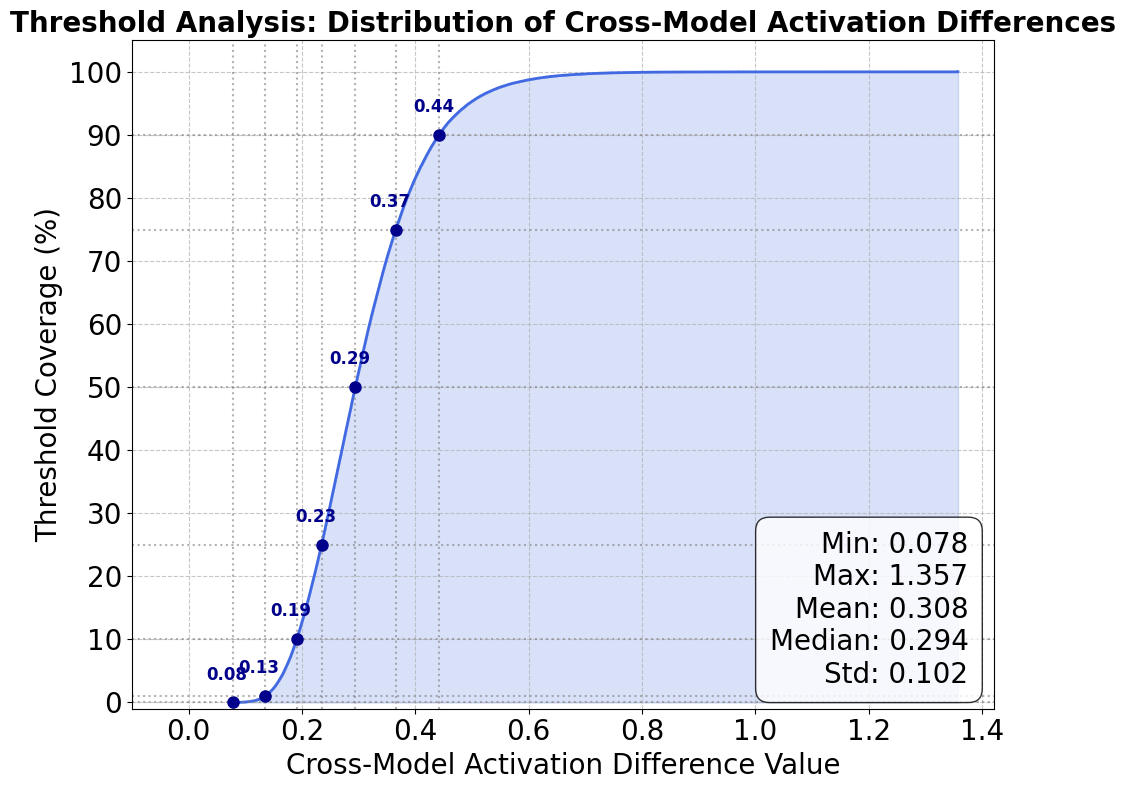

In [21]:
plt.figure(figsize=(10, 8))

sorted_data = test_case_avg['mean_cross_model_difference'].sort_values()

y_values = np.arange(1, len(sorted_data) + 1) / len(sorted_data) * 100

plt.step(sorted_data, y_values, where='post', color='royalblue', linewidth=2)
plt.fill_between(sorted_data, y_values, alpha=0.2, color='royalblue', step='post')

median_value = sorted_data.median()
median_idx = np.searchsorted(sorted_data, median_value)
median_y = y_values[min(median_idx, len(y_values)-1)]

# plt.axvline(x=median_value, color='red', linestyle='--', alpha=0.8)
# plt.text(median_value*1.05, 50, f"Median: {median_value:.3f}\n({median_y:.1f}%)", 
#         color='red', ha='left', va='center', fontweight='bold')

percentiles = [0,1,10,25, 50, 75, 90]
for pct in percentiles:
    percentile_value = sorted_data.quantile(pct/100)
    plt.axhline(y=pct, color='gray', linestyle=':', alpha=0.6)
    plt.axvline(x=percentile_value, color='gray', linestyle=':', alpha=0.6)
    plt.plot(percentile_value, pct, marker='o', color='darkblue', markersize=8)
    plt.text(percentile_value-0.01, pct+3, f"{percentile_value:.2f}", 
            color='darkblue', ha='center', va='bottom', fontweight='bold', fontsize=12)


n_tests = len(sorted_data)

plt.grid(True, linestyle='--', alpha=0.7)
plt.title(f'Threshold Analysis: Distribution of Cross-Model Activation Differences',fontweight='bold',fontsize=20)#\nFor {classes[the_class]} and {model_info} Model (n={n_tests} test cases)', fontsize=14)
plt.xlabel('Cross-Model Activation Difference Value',fontsize=20)
plt.ylabel('Threshold Coverage (%)', fontsize=20)
plt.xlim(left=-0.1)  # Start from 0
plt.ylim(-1, 105)  # Percentage goes from 0 to 100%

plt.yticks(np.arange(0, 101, 10))


stats_text = (f"Min: {sorted_data.min():.3f}\n"
              f"Max: {sorted_data.max():.3f}\n"
              f"Mean: {sorted_data.mean():.3f}\n"
              f"Median: {median_value:.3f}\n"
              f"Std: {sorted_data.std():.3f}")

plt.text(0.97, 0.03, stats_text, transform=plt.gca().transAxes, fontsize=20,
        verticalalignment='bottom', horizontalalignment='right',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.xticks(rotation=0,fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()

# Save plot
save_path = f'DCA-TS2.pdf'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

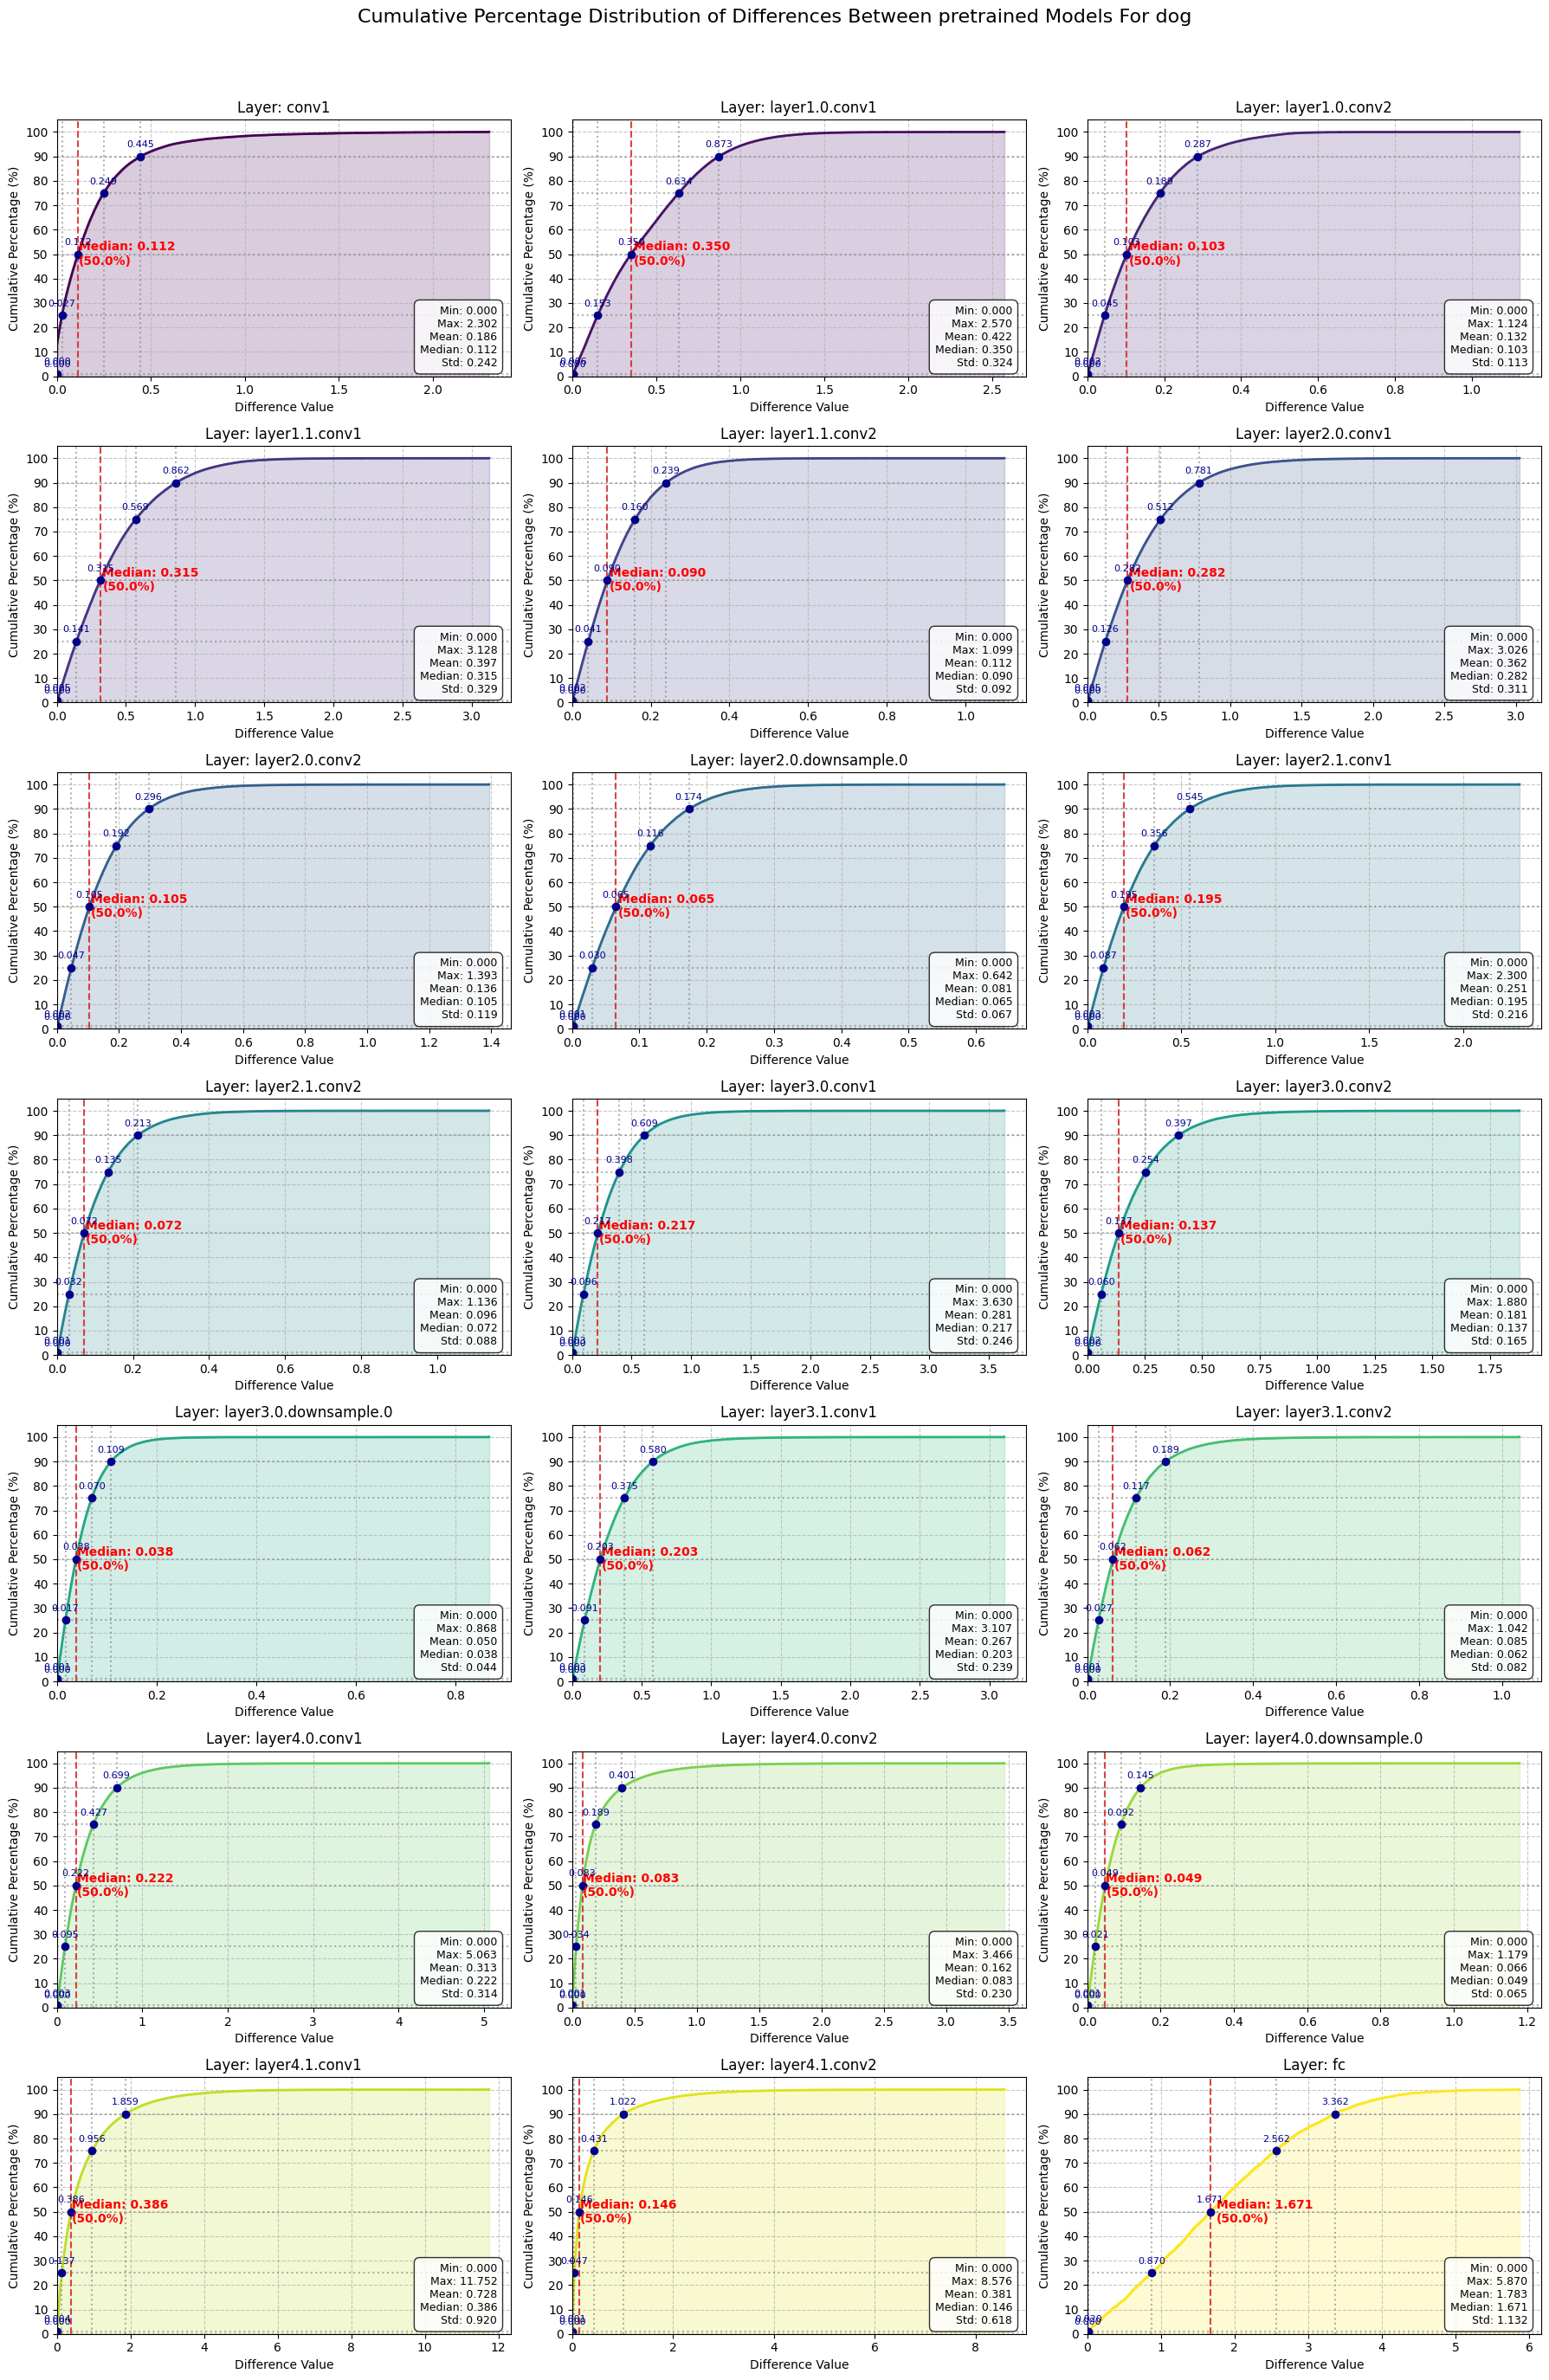

In [14]:
import math

layer_stats_df = pd.read_csv(f'{MODEL_NAME}_model_random_paths_for_{CLASSES[THE_CLASS]}_and_{K_ROUND}_Rounds.csv')
unique_layers = layer_stats_df['layer_name'].unique()
num_layers = len(unique_layers)
n_cols = min(3, num_layers) 
n_rows = math.ceil(num_layers / n_cols)

# Create a figure with subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4), squeeze=False)
fig.suptitle(f'Cumulative Percentage Distribution of Differences Between {MODEL_NAME} Models For {CLASSES[THE_CLASS]}', 
             fontsize=16, y=0.98)

# Create a colormap
colors = plt.cm.viridis(np.linspace(0, 1, num_layers))

# Flatten the axes array for easy indexing
axes_flat = axes.flatten()

# Plot cumulative histogram for each layer in its own subplot
for i, layer in enumerate(unique_layers):
    if i >= len(axes_flat):  # Safety check
        break
        
    ax = axes_flat[i]
    layer_data = layer_stats_df[layer_stats_df['layer_name'] == layer]['mean_cross_model_difference'].sort_values()
    
    # Calculate ECDF values as percentages
    y_values = np.arange(1, len(layer_data) + 1) / len(layer_data) * 100
    
    # Plot the ECDF
    ax.step(layer_data, y_values, where='post', color=colors[i], linewidth=2)
    ax.fill_between(layer_data, y_values, alpha=0.2, color=colors[i], step='post')
    
    # Add median value as a vertical line with text annotation
    median_value = layer_data.median()
    median_idx = np.searchsorted(layer_data, median_value)
    median_y = y_values[min(median_idx, len(y_values)-1)]
    
    ax.axvline(x=median_value, color='red', linestyle='--', alpha=0.8)
    ax.text(median_value*1.05, 50, f"Median: {median_value:.3f}\n({median_y:.1f}%)", 
            color='red', ha='left', va='center', fontweight='bold')
    
    # Add markers at specific percentiles (25%, 50%, 75%, 90%)
    percentiles = [0.001,1,25, 50, 75, 90]
    for pct in percentiles:
        # Find the x value at the specified percentile
        percentile_value = layer_data.quantile(pct/100)
        ax.axhline(y=pct, color='gray', linestyle=':', alpha=0.6)
        ax.axvline(x=percentile_value, color='gray', linestyle=':', alpha=0.6)
        ax.plot(percentile_value, pct, marker='o', color='darkblue', markersize=6)
        ax.text(percentile_value, pct+3, f"{percentile_value:.3f}", 
                color='darkblue', ha='center', va='bottom', fontsize=8)
    
    # Add grid, title, and labels
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_title(f'Layer: {layer}', fontsize=12)
    ax.set_xlabel('Difference Value')
    ax.set_ylabel('Cumulative Percentage (%)')
    ax.set_xlim(left=0)  # Start from 0
    ax.set_ylim(0, 105)  # Percentage goes from 0 to 100%
    
    # Add percentage y-ticks
    ax.set_yticks(np.arange(0, 101, 10))
    
    # Add statistics table in the corner
    stats_text = (f"Min: {layer_data.min():.3f}\n"
                  f"Max: {layer_data.max():.3f}\n"
                  f"Mean: {layer_data.mean():.3f}\n"
                  f"Median: {median_value:.3f}\n"
                  f"Std: {layer_data.std():.3f}")
    
    ax.text(0.97, 0.03, stats_text, transform=ax.transAxes, fontsize=9,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

# Hide any unused subplots
for j in range(i+1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust for the suptitle

# Save plot
save_path = f'{MODEL_NAME}_model_differences_cumulative_percent_by_layer_for_{CLASSES[THE_CLASS]} and {MODEL_NAME} Model.pdf'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [22]:
# Load the data
layer_stats_df = pd.read_csv(f'{MODEL_NAME}_model_random_paths_for_{CLASSES[THE_CLASS]}_and_{K_ROUND}_Rounds.csv')

# Prepare data
model1_df = layer_stats_df[['layer_name', 'model1_activation_value']].copy()
model1_df['Model'] = 'Model 1'
if isinstance(model1_df['model1_activation_value'].iloc[0], str):
    model1_df['activation_value'] = model1_df['model1_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model1_df['activation_value'] = model1_df['model1_activation_value']

model2_df = layer_stats_df[['layer_name', 'model2_activation_value']].copy()
model2_df['Model'] = 'Model 2'
if isinstance(model2_df['model2_activation_value'].iloc[0], str):
    model2_df['activation_value'] = model2_df['model2_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model2_df['activation_value'] = model2_df['model2_activation_value']

combined_df = pd.concat([
    model1_df[['layer_name', 'Model', 'activation_value']],
    model2_df[['layer_name', 'Model', 'activation_value']]
])

# Filter for last conv layer of each block
last_conv_layers = ['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.downsample.0',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.downsample.0',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.downsample.0',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'fc']

# Generate statistical summary table for last conv blocks only
print(f"Last Conv Layers Statistical Summary for {MODEL_NAME} - Class: {CLASSES[THE_CLASS]}")
print("=" * 80)

summary_data = []
for layer in last_conv_layers:
    if layer in combined_df['layer_name'].unique():
        model1_data = combined_df[(combined_df['layer_name'] == layer) & 
                                 (combined_df['Model'] == 'Model 1')]['activation_value']
        model2_data = combined_df[(combined_df['layer_name'] == layer) & 
                                 (combined_df['Model'] == 'Model 2')]['activation_value']
        
        summary_data.append({
            'Layer': layer,
            'Model1_Mean': f"{model1_data.mean():.4f}",
            'Model1_Median': f"{model1_data.median():.4f}",
            'Model1_Min': f"{model1_data.min():.4f}",
            'Model1_Max': f"{model1_data.max():.4f}",
            'Model2_Mean': f"{model2_data.mean():.4f}",
            'Model2_Median': f"{model2_data.median():.4f}",
            'Model2_Min': f"{model2_data.min():.4f}",
            'Model2_Max': f"{model2_data.max():.4f}"
        })

# Create and display table
stats_table = pd.DataFrame(summary_data)
print(stats_table.to_string(index=False))

last_conv_data = combined_df[combined_df['layer_name'].isin(last_conv_layers)]


Last Conv Layers Statistical Summary for pretrained - Class: dog
                Layer Model1_Mean Model1_Median Model1_Min Model1_Max Model2_Mean Model2_Median Model2_Min Model2_Max
                conv1      0.4340        0.2274     0.0000     8.0006      0.3779        0.1133     0.0000     8.2327
       layer1.0.conv1      0.7919        0.4375     0.0000     7.6300      0.5352        0.1658     0.0000     7.2273
       layer1.0.conv2      0.3404        0.2495     0.0000     3.0405      0.2933        0.2205     0.0000     2.4396
       layer1.1.conv1      0.6264        0.5314     0.0000     5.4117      0.4734        0.3381     0.0000     5.2905
       layer1.1.conv2      0.2643        0.2025     0.0000     3.0736      0.2170        0.1654     0.0000     2.5869
       layer2.0.conv1      0.7261        0.5611     0.0000     7.1402      0.6367        0.4730     0.0000     6.3773
       layer2.0.conv2      0.2372        0.1767     0.0000     2.4651      0.1765        0.0978     0.0000   

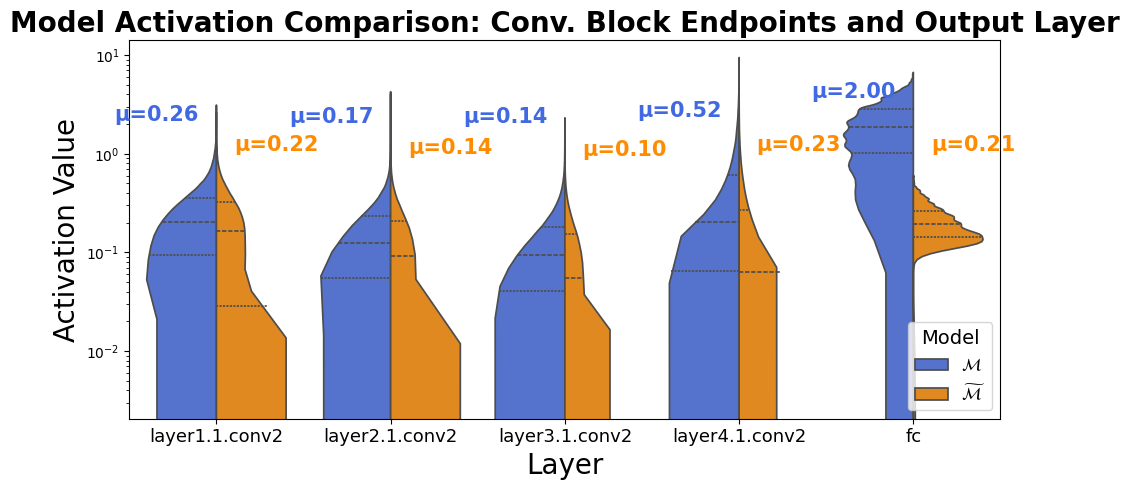

In [24]:
last_conv_layers = [
 'layer1.1.conv2',
 'layer2.1.conv2',
 'layer3.1.conv2',
 'layer4.1.conv2',
 'fc']
last_conv_data = combined_df[combined_df['layer_name'].isin(last_conv_layers)]

fig, ax = plt.subplots(figsize=(10, 5))
sns.violinplot(data=last_conv_data, 
               x='layer_name', 
               y='activation_value',
               hue='Model',
               inner='quartile',
               density_norm='width',
               split=True,
               palette={'Model 1': 'royalblue', 'Model 2': 'darkorange'})

for i, layer in enumerate(last_conv_data['layer_name'].unique()):

    model1_data = last_conv_data[(last_conv_data['layer_name'] == layer) & 
                             (last_conv_data['Model'] == 'Model 1')]['activation_value']
    model1_mean = model1_data.mean()
    model1_median = model1_data.median()
    model1_q1 = model1_data.quantile(0.25)
    model1_q3 = model1_data.quantile(0.75)
    
    
    model2_data = last_conv_data[(last_conv_data['layer_name'] == layer) & 
                             (last_conv_data['Model'] == 'Model 2')]['activation_value']
    model2_mean = model2_data.mean()
    model2_median = model2_data.median()
    model2_q1 = model2_data.quantile(0.25)
    model2_q3 = model2_data.quantile(0.75)
    
    
    plt.text(i-0.1, model1_mean+2.2, f"μ={model1_mean:.2f}", 
             ha='right', va='center', fontweight='bold', color='royalblue', fontsize=15)
    
    
    plt.text(i+0.1, model2_mean+1, f"μ={model2_mean:.2f}", 
             ha='left', va='center', fontweight='bold', color='darkorange', fontsize=15)
    
    
    stats_text = f"Model1: μ={model1_mean:.2f}, M={model1_median:.2f}\nModel2: μ={model2_mean:.2f}, M={model2_median:.2f}"
    # plt.text(i, ax.get_ylim()[0]+5, stats_text, 
    #          ha='center', va='top', fontsize=14, 
    #          bbox=dict(facecolor='white', alpha=0.5, boxstyle='round',pad=0.5))

plt.xticks(rotation=0,fontsize=13)
plt.title(f'Model Activation Comparison: Conv. Block Endpoints and Output Layer',fontsize=20,fontweight='bold',)#{model_info} - Model Activations For {classes[the_class]}')
plt.xlabel('Layer',fontsize=20)
plt.ylabel('Activation Value',fontsize=20)
plt.yscale('log')
#plt.ylim(0, 1e1)  # Adjust as needed

plt.tight_layout()
plt.legend(title='Model', fontsize=12, title_fontsize=14, loc='lower right')
# Save plot
save_path = f'MAC-TS2.pdf'
legend = ax.get_legend()
legend.get_texts()[0].set_text(r'$\mathcal{M}$')  # Model 1 -> M₁
legend.get_texts()[1].set_text(r'$\widetilde{\mathcal{M}}$')  # Model 2 -> M₂
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()

In [19]:
import numpy as np
from scipy.spatial.distance import jensenshannon

# Load the data
layer_stats_df = pd.read_csv(f'{MODEL_NAME}_model_random_paths_for_{CLASSES[THE_CLASS]}_and_{K_ROUND}_Rounds.csv')

# Process model1 data
model1_df = layer_stats_df[['layer_name', 'model1_activation_value']].copy()
model1_df['model'] = 'model1'
if isinstance(model1_df['model1_activation_value'].iloc[0], str):
    model1_df['activation_value'] = model1_df['model1_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model1_df['activation_value'] = model1_df['model1_activation_value']

# Process model2 data
model2_df = layer_stats_df[['layer_name', 'model2_activation_value']].copy()
model2_df['model'] = 'model2'
if isinstance(model2_df['model2_activation_value'].iloc[0], str):
    model2_df['activation_value'] = model2_df['model2_activation_value'].apply(
        lambda x: float(x.strip('[]')))
else:
    model2_df['activation_value'] = model2_df['model2_activation_value']

# Combine the dataframes
combined_df = pd.concat([
    model1_df[['layer_name', 'model', 'activation_value']],
    model2_df[['layer_name', 'model', 'activation_value']]
])

# Function to calculate Jensen-Shannon divergence
def calculate_js_divergence(p_values, q_values, bins=100):
    min_val = min(np.min(p_values), np.min(q_values))
    max_val = max(np.max(p_values), np.max(q_values))
    bin_edges = np.linspace(min_val, max_val, bins+1)
    
    p_hist, _ = np.histogram(p_values, bins=bin_edges, density=True)
    q_hist, _ = np.histogram(q_values, bins=bin_edges, density=True)
    
    # Normalize to get probability distributions
    p_hist = p_hist / np.sum(p_hist)
    q_hist = q_hist / np.sum(q_hist)
    
    # Calculate Jensen-Shannon divergence
    js_distance = jensenshannon(p_hist, q_hist)
    
    return js_distance

# Calculate JS divergence for last conv layers only
last_conv_layers = ['conv1', 'layer1.1.conv2', 'layer2.1.conv2', 'layer3.1.conv2', 'layer4.1.conv2', 'fc']

print(f"Jensen-Shannon Divergence for {MODEL_NAME} - Class: {CLASSES[THE_CLASS]}")
print("=" * 60)

for layer in last_conv_layers:
    if layer in combined_df['layer_name'].unique():
        layer_data = combined_df[combined_df['layer_name'] == layer]
        
        model1_values = layer_data[layer_data['model'] == 'model1']['activation_value'].values
        model2_values = layer_data[layer_data['model'] == 'model2']['activation_value'].values
        
        js_divergence = calculate_js_divergence(model1_values, model2_values)
        
        print(f"{layer}: {js_divergence:.6f}")


Jensen-Shannon Divergence for pretrained - Class: dog
conv1: 0.146048
layer1.1.conv2: 0.169590
layer2.1.conv2: 0.143275
layer3.1.conv2: 0.213167
layer4.1.conv2: 0.192274
fc: 0.728415


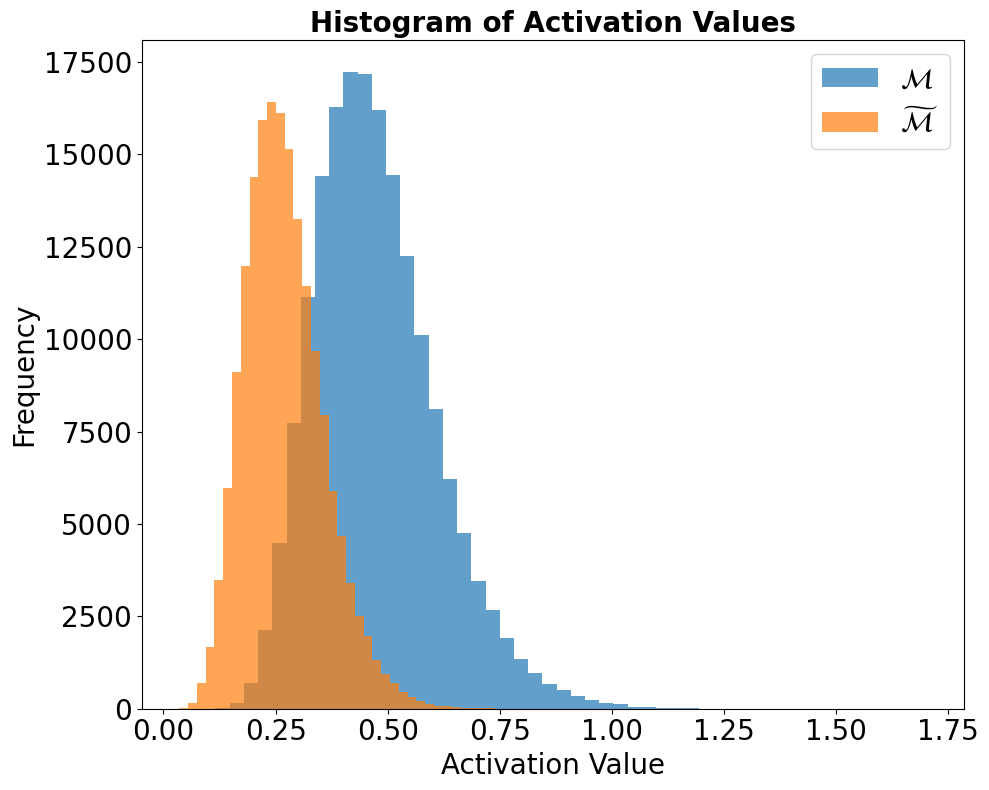

In [29]:
# Load the data
layer_stats_df = pd.read_csv(f'{MODEL_NAME}_model_random_paths_for_{CLASSES[THE_CLASS]}_and_{K_ROUND}_Rounds.csv')

if isinstance(layer_stats_df['model1_activation_value'].iloc[0], str):
    layer_stats_df['model1_activation_value'] = layer_stats_df['model1_activation_value'].apply(
        lambda x: float(x.strip('[]')))
    
if isinstance(layer_stats_df['model2_activation_value'].iloc[0], str):
    layer_stats_df['model2_activation_value'] = layer_stats_df['model2_activation_value'].apply(
        lambda x: float(x.strip('[]')))

# Directly aggregate by img_id and round
aggregated_df = layer_stats_df.groupby(['image_id', 'round']).agg({
    'model1_activation_value': 'mean',
    'model2_activation_value': 'mean'
}).reset_index()

# Create a histogram to visualize the aggregated activation distributions
plt.figure(figsize=(10, 8))

#plt.subplot(1, 2, 1)

plt.hist(aggregated_df['model1_activation_value'], bins=50, alpha=0.7, label=r'$\mathcal{M}$')
plt.hist(aggregated_df['model2_activation_value'], bins=50, alpha=0.7, label=r'$\widetilde{\mathcal{M}}$')
plt.xlabel('Activation Value',fontsize=20)
plt.ylabel('Frequency',fontsize=20)
plt.title('Histogram of Activation Values',fontweight='bold', fontsize=20)
plt.legend(fontsize=20)
# plt.subplot(1, 2, 2)

plt.xticks(rotation=0,fontsize=20)
plt.yticks(fontsize=20)

# legend = ax.get_legend()
# legend.get_texts()[0].set_text(r'$\mathcal{M}$')  # Model 1 -> M₁
# legend.get_texts()[1].set_text(r'$\widetilde{\mathcal{M}}$')  # Model 2 -> M₂

plt.tight_layout()
save_path = f'HAV-TS2.pdf'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
plt.show()